<h1><center> Continuous Control using Evolution Strategies </center></h1>

Evolution Strategies (ES) have proven to be an effective technique for training continuous as well as discrete control tasks. By making use of Gaussian perterubations in the weight space, ES eliminate the need for backpropagation and reduce the computation time by a significant extent when making use of parallelization. This has allowed scalability in the Reinforcement Learning paradigm.  

This tutorial is a naive implementation of ES proposed in OpenAI's [blog post](https://openai.com/blog/evolution-strategies/) and [paper](https://arxiv.org/pdf/1703.03864.pdf). A detailed implementation of OpenAI's version can be found at their [Github repository](https://github.com/openai/evolution-strategies-starter).  

<h3>NOTE-</h3> All implementations of ES (including this tutorial) require effective computational and parallelization resources such as multiple CPU cores. Experiments for this tutorial were conducted on a virtual AWS EC2 instance consisting of 96 CPU cores and 384 GB of memory. 

<h2>1. Import Dependencies</h2>
We make use of OpenAI's gym environments, namely the classic control and MuJoCo suite. Our model implementation is carried out in PyTorch. 

In [1]:
from google.colab import drive
user_name = '/content/drive'
drive.mount(user_name, force_remount=True)
import os
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
import CyclicMDP
from CyclicMDP import CyclicMDP
import time
import datetime
!pip install tensorboardX
!pip install --upgrade multiprocessing
!pip3 install box2d-py==2.3.8
!pip install roboschool==1.0.48
!pip install gym==0.15.4 
import tensorboardX
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.autograd import Variable
from torch import optim
from torch.distributions import MultivariateNormal
import pickle as pkl

import scipy.stats as ss
from tensorboardX import SummaryWriter
import gym, roboschool
checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Checkpoint/'
os.sched_setaffinity(os.getpid(), {0})
os.system("taskset -p 0xffffffff %d" % os.getpid())


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 204kB 5.0MB/s 
     |████████████████████████████████| 112kB 4.9MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.
     |████████████████████████████████| 450kB 4.9MB/s 
     |████████████████████████████████| 44.9MB 93kB/s 
     |████████████████████████████████| 1.6MB 4.5MB/s 
     |████████████████████████████████| 1.0MB 21.9MB/s 
  Created wheel for g

0

<h2>2. Network Architecture</h2>
We define a simple architecture consisting of Linear layers and $tanh$ activation. $tanh$ is a suitable choice here as all our action outputs being either torque values or physical force units in gym remain in the [-1,1] range. 

In [0]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [0]:
class NeuralNetwork(nn.Module):
    '''
    Neural network for continuous action space
    '''
    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_shape, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh())

        self.mean_l = nn.Linear(64, n_actions)
        self.mean_l.weight.data.mul_(0.1)

        self.var_l = nn.Linear(64, n_actions)
        self.var_l.weight.data.mul_(0.1)

        self.logstd = nn.Parameter(torch.zeros(n_actions))

    def forward(self, x):
        ot_n = self.mlp(x.float())
        return torch.tanh(self.mean_l(ot_n))



class Critic(nn.Module):
    '''
    Neural network for continuous action space
    '''
    def __init__(self, input_shape, n_actions):
        super(Critic, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_shape, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh())

        self.mean_l = nn.Linear(64, 1)
        self.mean_l.weight.data.mul_(0.1)

        self.var_l = nn.Linear(64, n_actions)
        self.var_l.weight.data.mul_(0.1)

        self.logstd = nn.Parameter(torch.zeros(n_actions))

    def forward(self, x):
        ot_n = self.mlp(x.float())
        return torch.tanh(self.mean_l(ot_n))



<h2>3. Evolution Strategies Module<h2/>

ES is genetic algorithm by origin and consists of multiple models. Each model is a part of a braoder set of models called the population. Models in a population are the offsprings from the parent model. Say we have a model (known as the parent model) and we perturb its weights by random Gaussian noise 100 times, we obtain a set of 100 new weights. Thus, we have 100 new models which can be optimized in the weight space. Upon running each of these models once we obtain the episodic reward and gauge their ability to learn. We then create a new model by taking a weighted average over the set of weights of the population. Models with higher returns are given higher preference over weak learners. In various implementations of Evolutionary Computing, only the top $x\%$ models are selected. This is called genetic selection. However, for the purpose of the tutorial we consider all the models in the population. 

The update rule for ES algorithm is mathematically expressed as-  

<center>$\theta_{t+1}\leftarrow \theta_{t} + \alpha\frac{1}{n\sigma}\sum_{i=1}^{n}F_{i}\epsilon_{i}$</center>

Here, $\theta_{t}$ are the parameters at time-step $t$, $\alpha$ the learning rate, $n$ the number of models in population or simply the population size, $\sigma$ the mutation parameter $F_{i}$ the reward corresponding to each model in the population and $\epsilon_{i}$ the Gaussian noise s.t. $\epsilon_{i} \sim \mathcal{N}(0,1)$.  


In [0]:
def sample_noise(neural_net):
    '''
    Sample noise for each parameter of the neural net
    '''
    nn_noise = []
    for n in neural_net.parameters():
        noise = np.random.normal(size=n.data.numpy().shape)
        nn_noise.append(noise)
    return np.array(nn_noise)

def evaluate_neuralnet(nn, env):
    '''
    Evaluate an agent running it in the environment and computing the total reward
    '''
    obs = env.reset()
    critic = Critic(STATE_DIM, ACTION_DIM)
    game_reward = 0
    tot_adv = 0

    while True:
        # Output of the neural net
        net_output = nn(torch.tensor(obs))
        state_val = critic(torch.tensor(obs))
        cov_mat = torch.diag(action_var)
        dist = MultivariateNormal(net_output, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        # the action is the value clipped returned by the nn
        # action = net_output.data.numpy().argmax()
        action = np.clip(action.data.cpu().numpy().squeeze(), -1, 1)
        # action = action.data.numpy().argmax()
        # action = np.asarray([action])
        new_obs, reward, done, _ = env.step(action)
        memory.states.append(obs)
        memory.actions.append(action)
        memory.rewards.append(reward)
        memory.logprobs.append(action_logprob)
        memory.is_terminals.append(done)

        obs = new_obs

        game_reward += reward

        advantages = (reward - state_val)
        tot_adv += advantages
        
        if done:
            break
        
    # print(torch.mean(torch.Tensor(tot_loss)), tot_adv)

    return game_reward, tot_adv.detach()

def evaluate_noisy_net(noise, neural_net, env):
    '''
    Evaluate a noisy agent by adding the noise to the plain agent
    '''
    old_dict = neural_net.state_dict()

    # add the noise to each parameter of the NN
    for n, p in zip(noise, neural_net.parameters()):
        p.data += torch.FloatTensor(n * STD_NOISE)

    # evaluate the agent with the noise
    reward, adv = evaluate_neuralnet(neural_net, env)
    # load the previous paramater (the ones without the noise)
    neural_net.load_state_dict(old_dict)
    
    return reward, adv

def worker(params_queue, output_queue):
    '''
    Function execute by each worker: get the agent' NN, sample noise and evaluate the agent adding the noise. Then return the seed and the rewards to the central unit
    '''

    env = gym.make(ENV_NAME)
    # env = CyclicMDP()
    actor = NeuralNetwork(STATE_DIM, ACTION_DIM)
    # actor = NeuralNetwork(3,3)
    while True:
        # get the new actor's params
        act_params = params_queue.get()
        if act_params != None:
            # load the actor params
            actor.load_state_dict(act_params)

            # get a random seed
            seed = np.random.randint(1e6)
            # set the new seed
            np.random.seed(seed)

            noise = sample_noise(actor)

            pos_rew, pos_adv = evaluate_noisy_net(noise, actor, env)
            # Mirrored sampling
            neg_rew, neg_adv = evaluate_noisy_net(-noise, actor, env)

            output_queue.put([[pos_rew, neg_rew], [pos_adv, neg_adv], seed])
        else:
            break


def normalized_rank(rewards):
    '''
    Rank the rewards and normalize them.
    '''
    ranked = ss.rankdata(rewards)
    norm = (ranked - 1) / (len(ranked) - 1)
    norm -= 0.5
    return norm


<h2>4. Training Loop</h2>

We execute the typical Reinforcement Learning training loop for a finite number of episodes. The parameter $MAX\_WORKERS$ should be handled carefully since training on multiple CPUs requires more processes and can often lead to poor performance. $\sigma$ is a tricky hyperparameter to tune. Often at times it will yield good evolutions in weight spaces but for some environments it may not lead to full convergence. 

In [12]:
rolling_rewards = []
max_rewards = []
min_rewards = []
avg_rewards = []
time_list = []
elite_learners = []

ENV_NAME = 'RoboschoolHopper-v1'
env = gym.make(ENV_NAME)
# env = CyclicMDP()

# Hyperparameters
UPD_INTERVAL = 10
EPOCHS = 40
EPS_CLIP = 0.2
STD_NOISE = 0.05
BATCH_SIZE = 20
LEARNING_RATE = 0.01
MAX_ITERATIONS = 3000
ACTION_STD = 0.5
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]
action_var = torch.full((ACTION_DIM,), ACTION_STD*ACTION_STD)
batch_oldlogprob = torch.zeros((BATCH_SIZE*2))

MAX_WORKERS = 4

save_video_test = False
VIDEOS_INTERVAL = 100

now = datetime.datetime.now()
date_time = "{}_{}.{}.{}".format(now.day, now.hour, now.minute, now.second)

if __name__ == '__main__':
    # Writer name
    writer_name = 'ASY_ES_{}_{}_{}_{}_{}_{}'.format(ENV_NAME, date_time, str(STD_NOISE), str(BATCH_SIZE), str(LEARNING_RATE), str(MAX_ITERATIONS), str(MAX_WORKERS))
    print('Name:', writer_name)

    # Create the test environment
    if save_video_test:
        env = gym.wrappers.Monitor(env,  "VIDEOS/TEST_VIDEOS_"+writer_name, video_callable=lambda episode_id: True)

    # Initialize the agent
    actor = NeuralNetwork(STATE_DIM, ACTION_DIM)
    critic = Critic(STATE_DIM, ACTION_DIM)
    # actor = NeuralNetwork(3,3)

    # Initialize the optimizer
    optimizer = optim.Adam(actor.parameters(), lr=LEARNING_RATE)
    MseLoss = nn.MSELoss()

    writer = SummaryWriter(log_dir='content/runs/'+writer_name)

    # Queues to pass and get the variables to and from each processe
    output_queue = mp.Queue(maxsize=BATCH_SIZE)
    params_queue = mp.Queue(maxsize=BATCH_SIZE)

    processes = []
    memory = Memory()

    # Create and start the processes
    for _ in range(MAX_WORKERS):
        p = mp.Process(target=worker, args=(params_queue, output_queue))
        p.start()
        processes.append(p)


    # Execute the main loop MAX_ITERATIONS times
    for n_iter in range(1,MAX_ITERATIONS+1):
        it_time = time.time()

        batch_noise = []
        batch_reward = []
        batch_loss = []
        batch_ratio = []
        batch_adv = []

        ############################### ACTOR-CRITIC UPDATE ##################################

        if n_iter % UPD_INTERVAL == 0:
          old_states = torch.squeeze(torch.stack(memory.states), 1).detach()
          old_actions = torch.squeeze(torch.stack(memory.actions), 1).detach()
          old_logprobs = torch.squeeze(torch.stack(memory.logprobs), 1).detach()

          for _ in range(EPOCHS):

            # Optimize policy for K epochs:
            for _ in range(self.K_epochs):
                # Evaluating old actions and values :
                action_mean = self.actor(old_states)
                
                action_var = self.action_var.expand_as(action_mean)
                cov_mat = torch.diag_embed(action_var).to(device)
                
                dist = MultivariateNormal(action_mean, cov_mat)
                
                action_logprobs = dist.log_prob(old_actions)
                dist_entropy = dist.entropy()
                state_value = self.critic(old_states)
                
                # Finding the ratio (pi_theta / pi_theta__old):
                ratios = torch.exp(action_logprobs - old_logprobs.detach())

                # Finding Surrogate Loss:
                advantages = rewards - state_values.detach()
                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1-EPS, 1+EPS) * advantages
                loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
                
                # take gradient step
                self.optimizer.zero_grad()
                loss.mean().backward()
                self.optimizer.step()
            
            memory.clear_memory()    
        #------------------------------------------------------------------------------#


        # create the queue with the actor parameters
        for _ in range(BATCH_SIZE):
            params_queue.put(actor.state_dict())
        
        # receive from each worker the results (the seed and the rewards)
        for i in range(BATCH_SIZE):
            p_rews, p_adv, p_seed = output_queue.get()

            np.random.seed(p_seed)
            noise = sample_noise(actor)
            batch_noise.append(noise)
            batch_noise.append(-noise)

            batch_reward.append(p_rews[0]) # reward of the positive noise
            batch_reward.append(p_rews[1]) # reward of the negative noise

            batch_adv.append(p_adv[0]) # adv for positive noise
            batch_adv.append(p_adv[1]) # adv for negative noise

        batch_adv = torch.FloatTensor(batch_adv)

        ############################# JUST PRINTING DATA ##############################
        avg_reward = np.round(np.mean(batch_reward), 2)
        print(n_iter, 'Mean:',avg_reward, 'Max:', np.round(np.max(batch_reward), 2), 'Time:', np.round(time.time()-it_time, 2))
        writer.add_scalar('reward', np.mean(batch_reward), n_iter)
        if len(avg_rewards)>10:
          rolling_rewards.append(np.mean(avg_rewards[-10:]))
        max_rewards.append(np.max(batch_reward))
        min_rewards.append(np.min(batch_reward))
        avg_rewards.append(avg_reward)
        time_list.append(time.time()-it_time)
        count = 0
        for k in batch_reward:
          if k > avg_reward:
            count += 1
        elite_learners.append(count)
            
        #------------------------------------------------------------------------------#


        ################################## ES UPDATE ##################################
        
        # Rank the reward and normalize it
        batch_reward = torch.FloatTensor(normalized_rank(batch_reward))
        
        th_update = []
        optimizer.zero_grad()
        # for each actor's parameter, and for each noise in the batch, update it by the reward * the noise value
        for idx, p in enumerate(actor.parameters()):
            upd_weights = torch.zeros(p.data.shape)
            # upd_weights -= min(1-ratios,torch.clamp(1-ratios,-EPS_CLIP,EPS_CLIP)) * batch_reward * torch.Tensor(n[idx])

            for n,r in zip(batch_noise, batch_adv):
                if r >= torch.mean(batch_reward):
                  upd_weights += (r) * torch.Tensor(n[idx])#min(a,torch.clamp(a,1-EPS_CLIP,1+EPS_CLIP)) * 
                # upd_weights += min(1-a,torch.clamp(1-a,-EPS_CLIP,EPS_CLIP)) * r * torch.Tensor(n[idx])

            upd_weights = upd_weights / (BATCH_SIZE*STD_NOISE)
            # put the updated weight on the gradient variable so that afterwards the optimizer will use it
            p.grad = torch.FloatTensor( -upd_weights).clone()

        # Optimize the actor's NN
        optimizer.step()


        if n_iter % VIDEOS_INTERVAL == 0:
            # print('Test reward:',evaluate_neuralnet(actor, env))
            torch.save({'model_state_dict': actor.state_dict(), 'optimizer_state_dict': optimizer.state_dict()},
                       checkpoint_name+'/actor.pth.tar')
        
        #-----------------------------------------------------------------------------#
                    
    # quit the processes
    for _ in range(MAX_WORKERS):
        params_queue.put(None)

    for p in processes:
        p.join()

    data_save = {}
    data_save['elite_learners'] = elite_learners
    data_save['time'] = time_list
    data_save['rolling_rewards'] = rolling_rewards
    data_save['max_rewards'] = max_rewards
    data_save['min_reward'] = min_rewards
    data_save['avg_reward'] = avg_rewards

    with open(checkpoint_name+'data.pkl', 'wb') as f:
        pkl.dump(data_save, f)

    


Name: ASY_ES_RoboschoolHopper-v1_8_23.23.31_0.05_20_0.01_3000
1 Mean: 24.87 Max: 32.8 Time: 0.94
2 Mean: 22.66 Max: 27.39 Time: 0.74
3 Mean: 24.65 Max: 30.93 Time: 0.92
4 Mean: 27.03 Max: 44.72 Time: 1.05
5 Mean: 24.71 Max: 36.19 Time: 0.91
6 Mean: 24.12 Max: 33.64 Time: 0.88
7 Mean: 24.24 Max: 32.29 Time: 0.89
8 Mean: 24.89 Max: 46.18 Time: 0.97
9 Mean: 24.81 Max: 35.27 Time: 0.97


RuntimeError: ignored

[]


<h2>5. Visualize Results</h2>

As always, it is good practice to view the performance of our algorithm. In the case of ES we visualize the episodic and average rewards. We also gain intuition of the overall performance of our population by taking into the number of elite learners, which are defined as the number of models above the average score. As the population converges to a global minima, the number of elite learners increase to a constant indicating the successful convergence of the overall population.  

Here are some of the tasks and the performance of our agents-  

<img src="gifs/Hopper.gif" align="left" height="200" width="200" /><img src="gifs/Swimmer.gif" align="left" height="200" width="200" /><img src="gifs/HalfCheetah.gif" align="left" height="200" width="200" /><img src="gifs/InvertedPendulum.gif" align="left" height="200" width="200" />
<img src="gifs/Reacher.gif" align="left" height="200" width="200" /><img src="gifs/Humanoid.gif" align="left" height="200" width="200" /><img src="gifs/BipedalWalker.gif" align="left" height="200" width="200" /><img src="gifs/LunarLander.gif" align="left" height="200" width="200" />

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


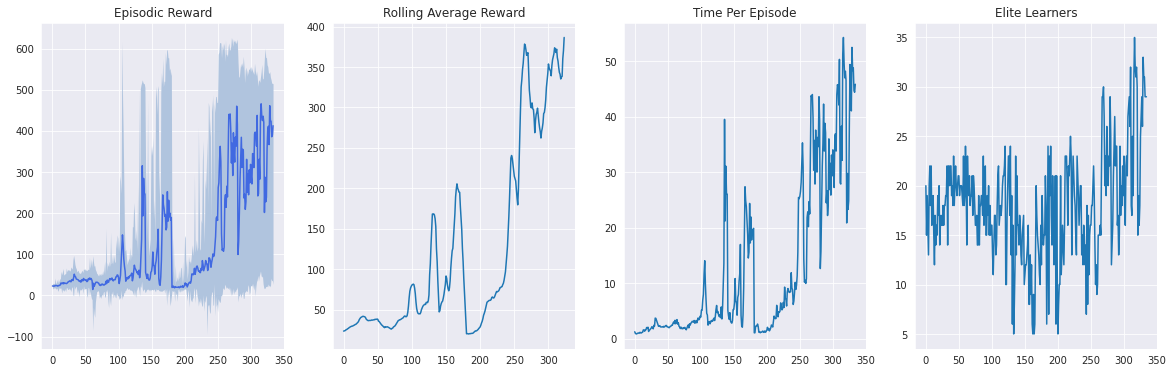

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark', {'axes.grid' : True})

plt.figure(figsize=(20,6))

plt.subplot(141)
plt.title('Episodic Reward')
plt.plot(np.arange(0,len(avg_rewards),1),avg_rewards, color='royalblue')
plt.fill_between(np.arange(0,len(avg_rewards),1),min_rewards,max_rewards,facecolor='lightsteelblue',linewidth=0)


plt.subplot(142)
plt.title('Rolling Average Reward')
plt.plot(rolling_rewards)

plt.subplot(143)
plt.title('Time Per Episode')
plt.plot(time_list)

plt.subplot(144)
plt.title('Elite Learners')
plt.plot(elite_learners)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


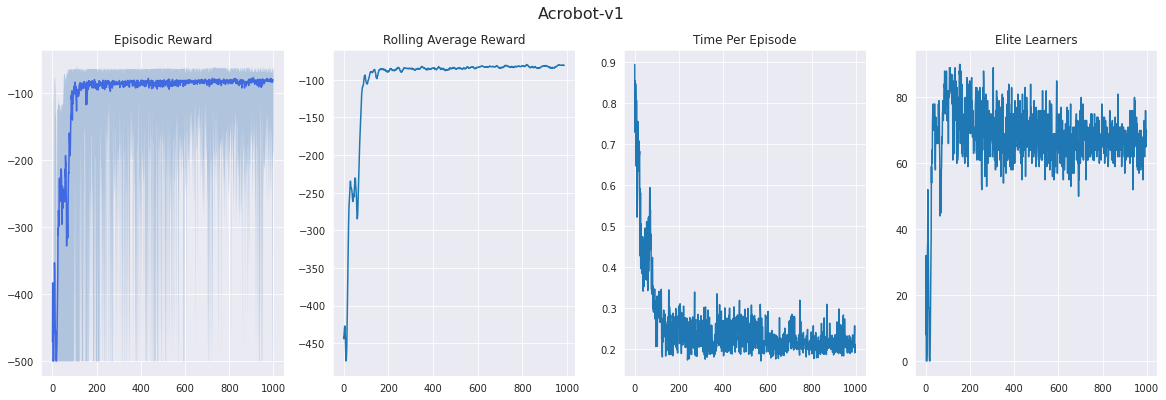

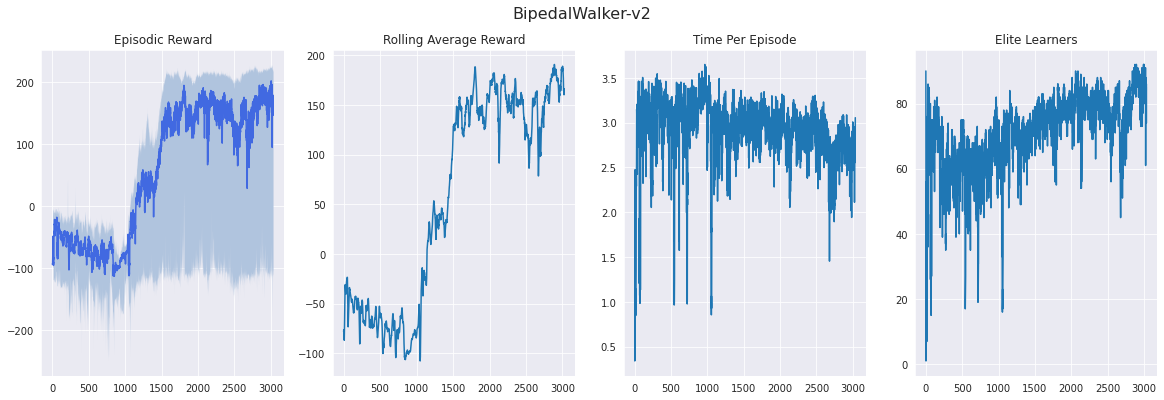

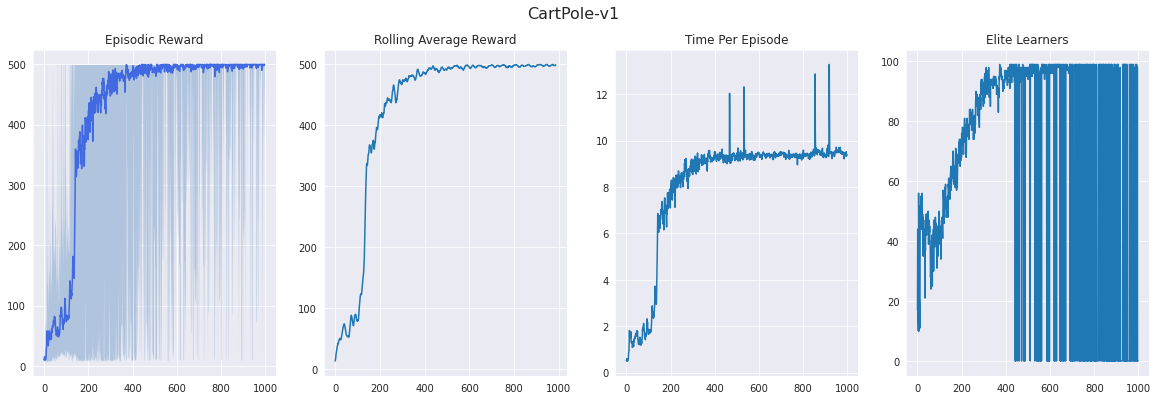

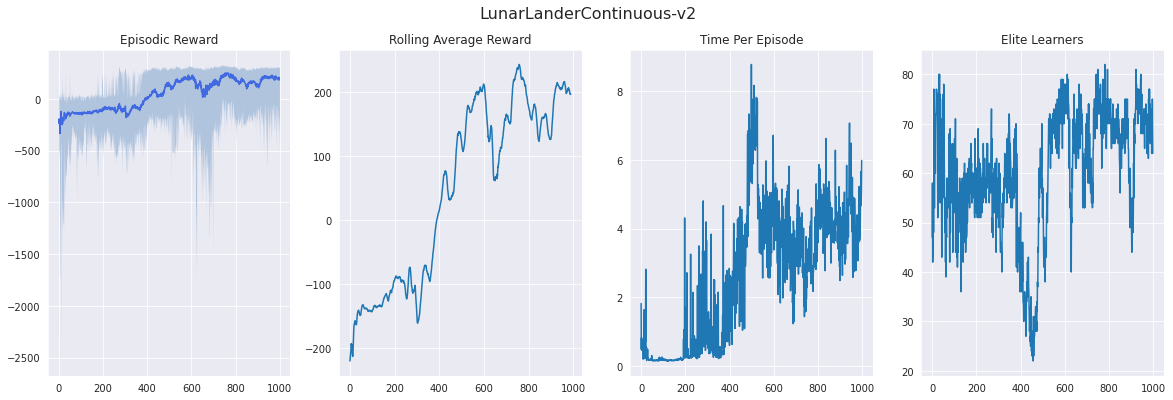

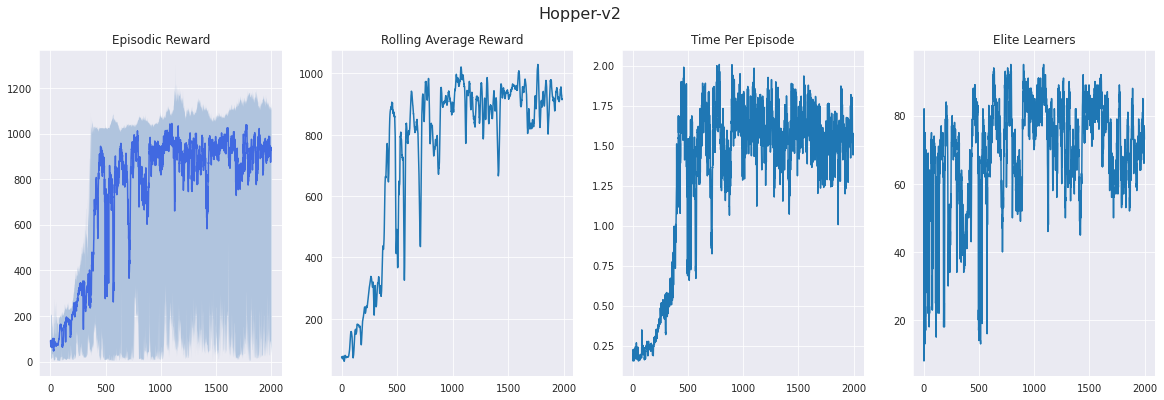

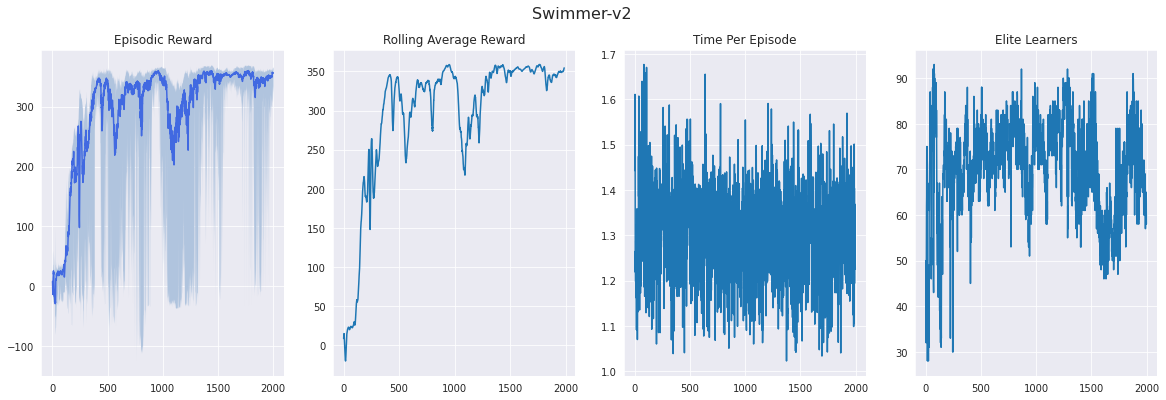

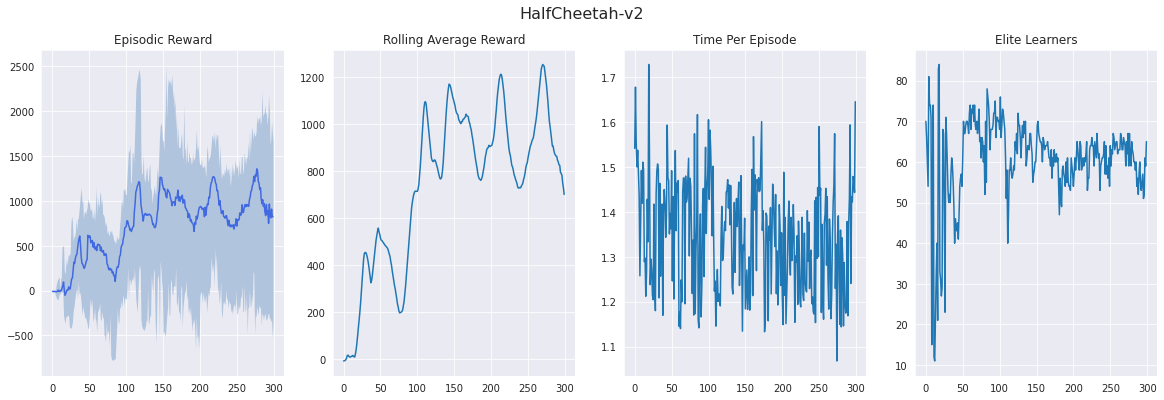

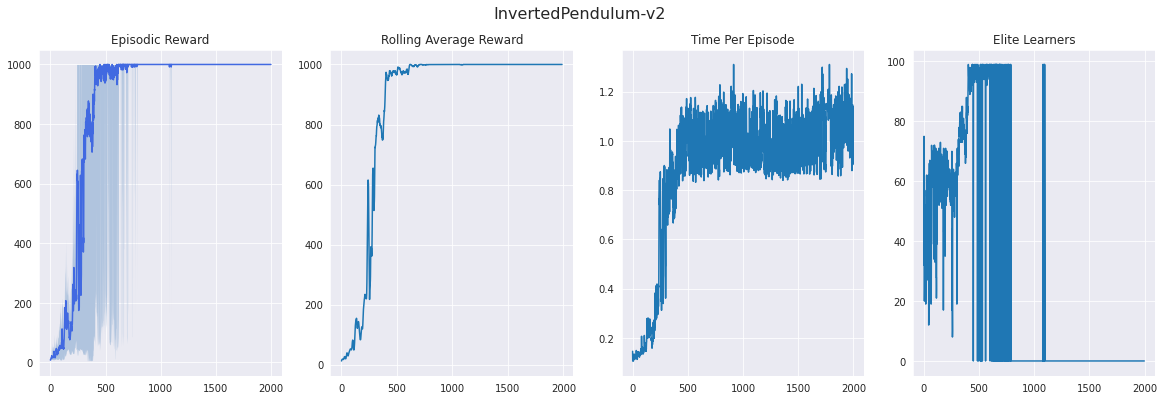

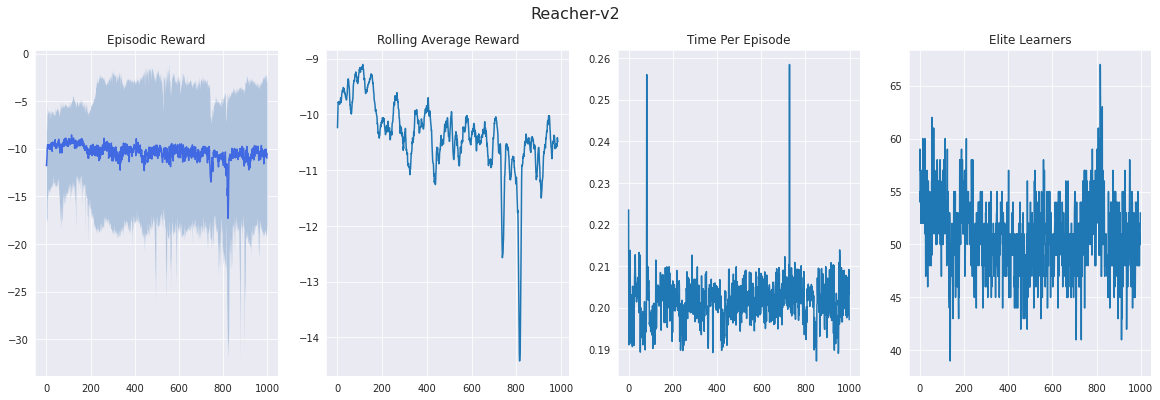

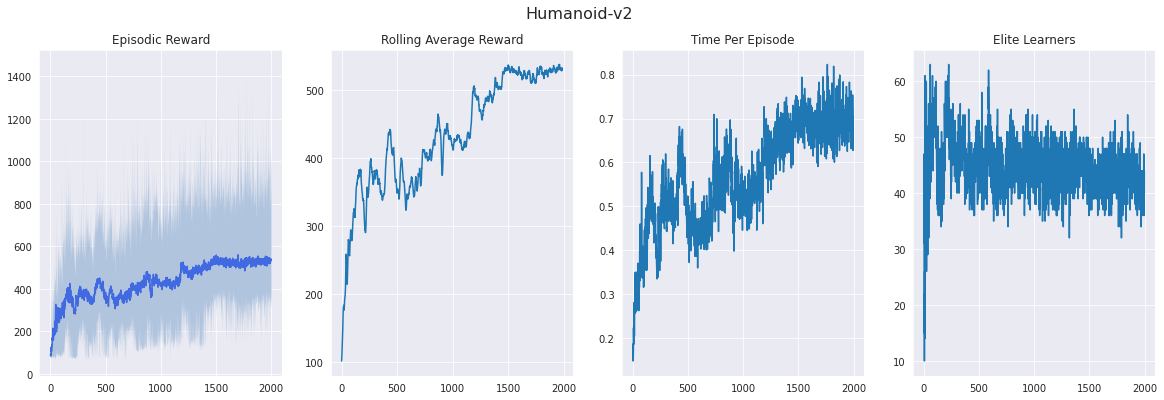

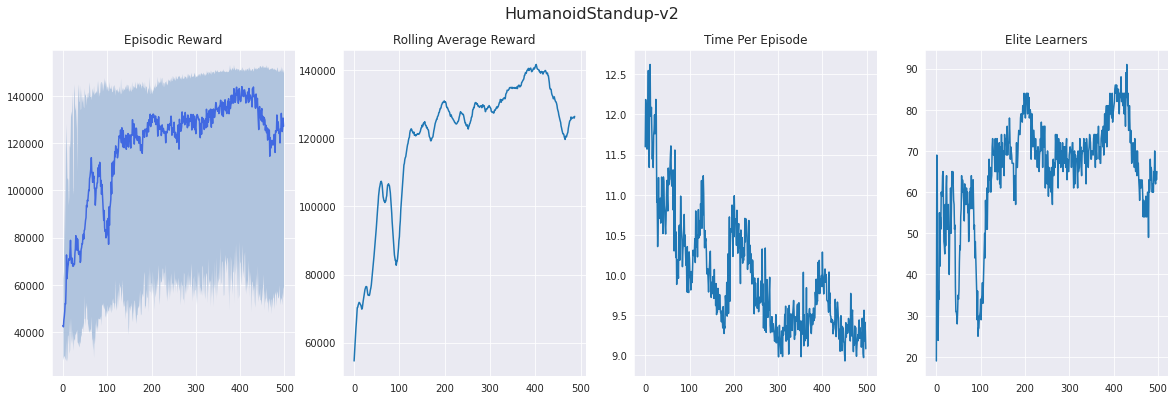

In [0]:
env_list = ['Acrobot-v1','BipedalWalker-v2','CartPole-v1','LunarLanderContinuous-v2','Hopper-v2','Swimmer-v2','HalfCheetah-v2',
            'InvertedPendulum-v2','Reacher-v2','Humanoid-v2','HumanoidStandup-v2']
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark', {'axes.grid' : True})

for j in env_list:
  check_name = checkpoint_name+j+'/data.pkl'
  data = pkl.load(open(check_name,'rb'))
  if j=='HalfCheetah-v2':
    x = 300
  else:
    x = -1
  avg_rewards = data['avg_reward'][:x]
  max_rewards = data['max_rewards'][:x]
  min_rewards = data['min_reward'][:x]
  rolling_rewards = data['rolling_rewards'][:x]
  time_list = data['time'][:x]
  elite_learners = data['elite_learners'][:x]

  plt.figure(figsize=(20,6))
  plt.suptitle(j,fontsize='16')

  plt.subplot(141)
  plt.title('Episodic Reward')
  plt.plot(np.arange(0,len(avg_rewards),1),avg_rewards, color='royalblue')
  plt.fill_between(np.arange(0,len(avg_rewards),1),min_rewards,max_rewards,facecolor='lightsteelblue',linewidth=0)

  plt.subplot(142)
  plt.title('Rolling Average Reward')
  plt.plot(rolling_rewards)

  plt.subplot(143)
  plt.title('Time Per Episode')
  plt.plot(time_list)

  plt.subplot(144)
  plt.title('Elite Learners')
  plt.plot(elite_learners)


<h2>6. References</h2>

1. [OpenAI Blog](https://openai.com/blog/evolution-strategies/)
2. [Paper](https://arxiv.org/pdf/1703.03864.pdf)
3. [Github Repository](https://github.com/openai/evolution-strategies-starter)